In [1]:
import pickle

# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers

# Maths modules
from scipy.stats import f_oneway
import pandas as pd

# Viz modules
import plotly.express as px

# Render for export
import plotly.io as pio

pio.renderers.default = "notebook"


In [2]:
# Download and unzip CSV files
!cd .. && make dataset && cd notebooks

>>> Downloading and extracting data files...
Data files already downloaded.
>>> OK.



In [3]:
# Load data from CSV
df = pd.read_csv(
    os.path.join(
        "..", "data", "raw", "training.1600000.processed.noemoticon.csv"
    ),
    names=["target", "id", "date", "flag", "user", "text"],
)

# Reduce memory usage
df = data_helpers.reduce_dataframe_memory_usage(df)


In [4]:
# Drop useless columns
df.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
df.target.replace(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    },
    inplace=True,
)


In [5]:
# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizers, Stemmers and Lemmatizers
import nltk
from nltk.corpus import stopwords
import spacy

# Download resources
nltk.download("stopwords")
stopwords = set(stopwords.words("english"))

# Download SpaCy model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Define tokenizer
tokenizer = lambda text: [  # SpaCy Lemmatizer
    token.lemma_.lower()
    for token in nlp(text)
    if token.is_alpha and not token.is_stop
]

# Processed data path
processed_data_path = os.path.join("..", "data", "processed")
tokenized_dataset_file_path = os.path.join(processed_data_path, "spacy_dataset.pkl")

if os.path.exists(tokenized_dataset_file_path):
    # Load tokenized dataset
    with (open(tokenized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
else:
    # Tokenize dataset
    X = df.text.apply(tokenizer)

    # Save tokenized dataset as pickle
    with open(tokenized_dataset_file_path, "wb") as f:
        pickle.dump(X, f)


2022-01-06 11:34:24.429125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 11:34:24.429146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-01-06 11:34:27.423563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 11:34:27.423596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 3.0 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec


# Processed data path
processed_data_path = os.path.join("..", "data", "processed")
vectorized_dataset_file_path = os.path.join(processed_data_path, "doc2vec_spacy_dataset.pkl")

if os.path.exists(vectorized_dataset_file_path):
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
else:
    # Tag documents for training
    X = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]

    # Train doc2vec model
    doc2vec = Doc2Vec()
    doc2vec.build_vocab(X)
    doc2vec.train(X)

    # Vectorize text
    X = [doc2vec.infer_vector(doc.words) for doc in X]

    # Save vectorized dataset as pickle
    with open(vectorized_dataset_file_path, "wb") as f:
        pickle.dump(X, f)


In [ ]:
from sklearn.model_selection import train_test_split


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    df.target,
    test_size=0.2,
    stratify=df.target,
    random_state=42,
)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV


# Define model
model = LogisticRegressionCV(random_state=42)

# Train model
model.fit(X_train, y_train)


LogisticRegressionCV(random_state=42)

In [ ]:
# Comute the coefficients
dimensions = [f"Dimension {i + 1}" for i in range(len(X[0]))]
coefs = pd.Series(
    model.coef_[0],
    index=dimensions,
)

# Top 20 topics by importance (positive and negative)
top_20_coefs = (
    coefs.nlargest(10).append(coefs.nsmallest(10)).sort_values()
)

# Plot top 20 topics by importance (positive and negative)
fig = px.bar(
    top_20_coefs,
    x=top_20_coefs.index,
    y=top_20_coefs.values,
    labels={"x": "Dimension", "y": "Importance", "color": "Importance"},
    title=f"Top 20 important dimensions",
    color=top_20_coefs.values,
)
fig.show()


/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.R

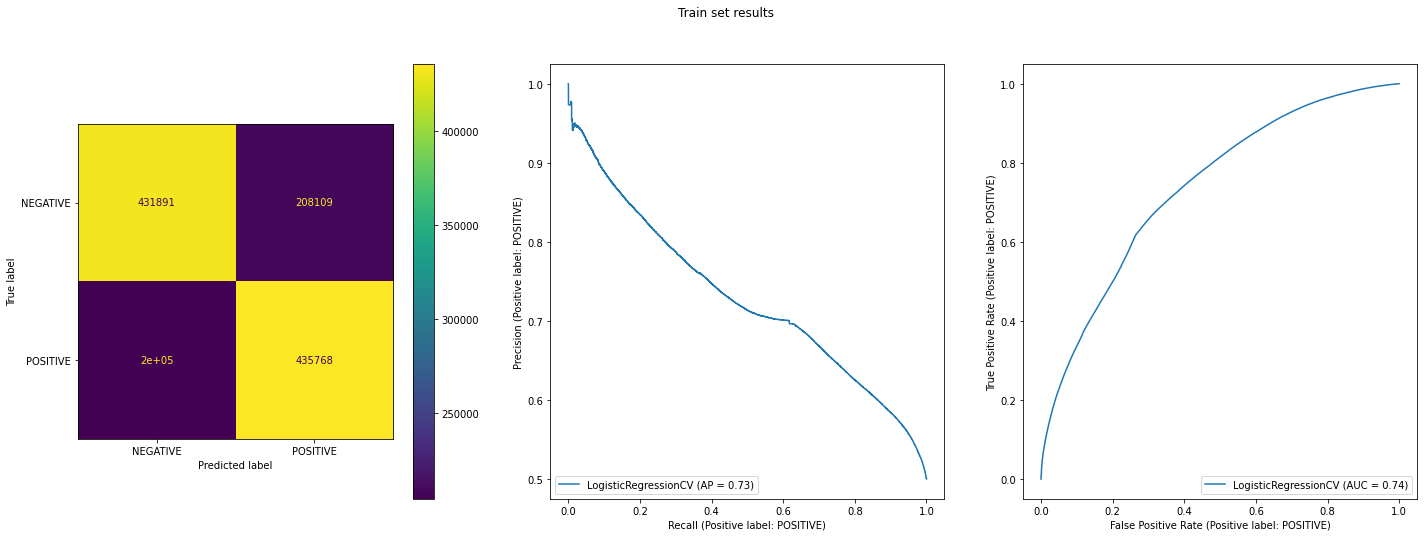

In [ ]:
viz_helpers.plot_classifier_results(
    model,
    X_train,
    y_train,
    title="Train set results",
)


/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.

/home/clement/Workspace/oc_p7/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.R

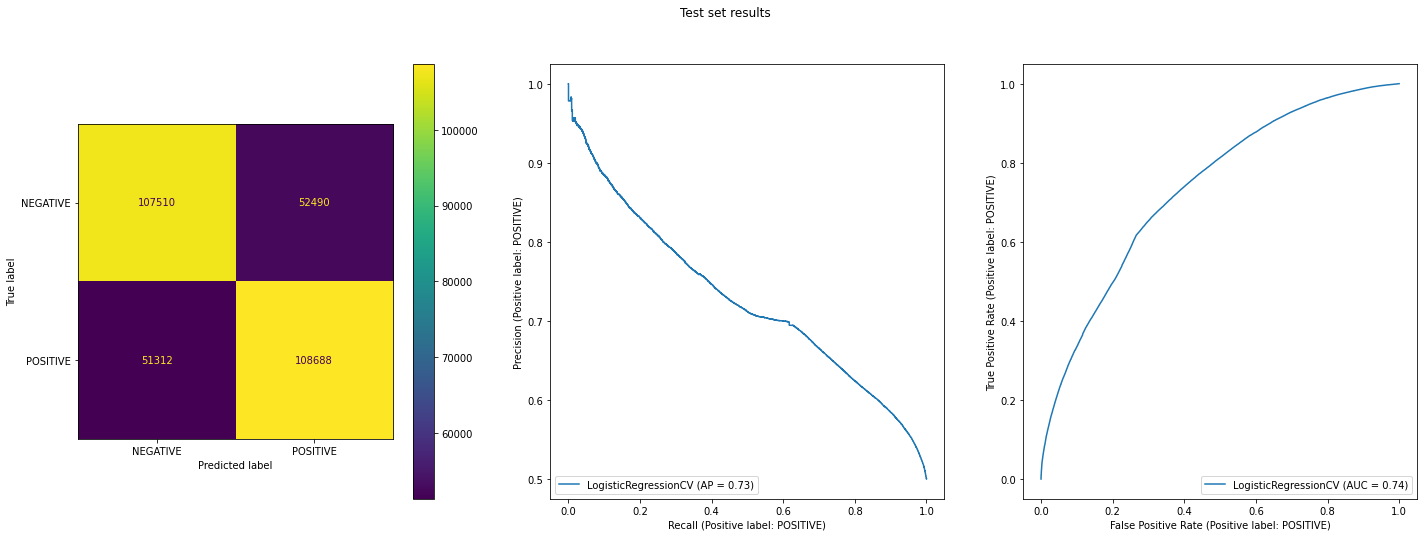

In [ ]:
viz_helpers.plot_classifier_results(
    model,
    X_test,
    y_test,
    title="Test set results",
)


The performances on the train and test datasets are identical, so we know our model is well trained (no over/under-fitting). 

The performances are quite correct for a baseline model : 
- Average Precision = 0.73
- ROC AUC = 0.74

Our model is biased towards the _POSITIVE_ class : it predicted 35% more _POSITIVE_ (918049) messages than _NEGATIVE_ (681951).

Let's observe some classification errors.

In [ ]:
# Compute predictions
y_pred = model.predict(X_lsa)
df["prediction"] = y_pred


In [ ]:
import shap

shap.initjs()

explainer = shap.Explainer(model, X_train, feature_names=topics)
shap_values = explainer(X)


Linear explainer: 1600001it [00:14, 31615.45it/s]                              


In [ ]:
# False positive example
fp_index = df[(df.target == "NEGATIVE") & (df.prediction == "POSITIVE")].index[0]
fp_text = df.text.values[fp_index]

print(fp_text)

shap.plots.force(shap_values[fp_index])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


On this false-positive example, we can see that the model is not able to predict the sentiment of the message, despite words like "bummer" and "should"...

In [ ]:
# False negative example
fn_index = df[(df.target == "POSITIVE") & (df.prediction == "NEGATIVE")].index[0]
fn_text = df.text.values[fn_index]

print(fn_text)

shap.plots.force(shap_values[fn_index])

Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup


On this false-negative example, we can see that the model is not able to predict the sentiment of the message. But in this case, the model is fooled by the presence of words like "sick", "cheap", "hurts", ...